In [5]:
# 将代码重构为函数形式，便于多次调用分析不同时间步
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
from scipy import stats
from scipy.optimize import curve_fit

# 设置全局字体为 Times New Roman
# 修改全局字体设置为Arial并加粗
# 设置全局字体为 Times New Roman
# 修改全局字体设置为Arial并加粗
rcParams['font.family'] = 'Arial'
rcParams['font.weight'] = 'bold'  # 加粗字体
rcParams['axes.labelweight'] = 'bold'  # 加粗轴标签
rcParams['axes.titleweight'] = 'bold'  # 加粗标题
rcParams['axes.linewidth'] = 2.0  # 加粗轴边框(原来1.5的两倍)
rcParams['xtick.major.width'] = 2.0  # 加粗x轴刻度(原来1.5的两倍)
rcParams['ytick.major.width'] = 2.0  # 加粗y轴刻度(原来1.5的两倍)
rcParams['xtick.labelsize'] = 16  # 设置刻度标签大小(原来12的两倍)
rcParams['ytick.labelsize'] = 16  # 设置刻度标签大小(原来12的两倍)
rcParams['font.size'] = 16  # 添加基础字体大小设置
rcParams['axes.labelsize'] = 20  # 添加轴标签字体大小
rcParams['axes.titlesize'] = 20  # 添加标题字体大小
rcParams['legend.fontsize'] = 16  # 添加图例字体大小


def load_parameters(data_dir):
    """加载参数文件"""
    params = pd.read_csv(os.path.join(data_dir, 'parameters.csv'), index_col=0)
    Lx = params.loc['Lx', 'Value']
    Ly = params.loc['Ly', 'Value']
    afr = params.loc['afr', 'Value']
    return Lx, Ly, afr

def load_index(data_dir):
    """加载索引文件"""
    index_df = pd.read_csv(os.path.join(data_dir, 'index.csv'))
    return index_df

def load_timestep_data(data_dir, time_step, index_df):
    """加载特定时间步的数据"""
    step_info = index_df[index_df['time_step'] == time_step]
    
    if not step_info.empty and step_info.iloc[0]['num_points'] > 0:
        filename = step_info.iloc[0]['filename']
        data = pd.read_csv(os.path.join(data_dir, filename))
        return data, filename
    else:
        return None, None

# 定义拟合函数
def power_law(x, a, b):
    """幂律函数: y = a|x|^b"""
    return a * np.abs(x)**b

def exp_func(x, a, b):
    """指数函数: y = a*exp(b*x)"""
    return a * np.exp(b * x)

def analyze_single_timestep(data_dir, time_step):
    """分析单个时间步的数据"""
    # 加载参数和索引
    Lx, Ly, afr = load_parameters(data_dir)
    index_df = load_index(data_dir)
    print(f"Total time steps: {len(index_df)}")
    
    # 加载时间步数据
    data, filename = load_timestep_data(data_dir, time_step, index_df)
    
    if data is not None:
        # 提取数据
        x = data['x'].values
        y = data['y'].values
        angles = data['angle'].values
        curvatures = data['curvature'].values
        
        # 可视化
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        # 绘制位置和曲率
        sc = ax1.scatter(x, y, c=curvatures, cmap='jet')
        ax1.set_xlabel('X coordinate')
        ax1.set_ylabel('Y coordinate')
        ax1.set_title(f'Interface points at time step {time_step}')
        ax1.grid(True)
        ax1.set_aspect('equal')
        
        # 设置固定显示范围为给定大小的一半
        ax1.set_xlim(0, Lx)
        ax1.set_ylim(0, Ly)
        
        fig.colorbar(sc, ax=ax1, label='Curvature')
        
        # 绘制角度与曲率的关系
        ax2.plot(angles, curvatures, 'b-')
        ax2.set_xlabel('Angle (degrees)')
        ax2.set_ylabel('Curvature')
        ax2.set_title('Curvature vs. Angle')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # 分析曲率
        print(f"Mean curvature: {np.mean(curvatures):.6f}")
        print(f"Max curvature: {np.max(curvatures):.6f}")
        print(f"Min curvature: {np.min(curvatures):.6f}")
        
        return data
    else:
        print(f"Time step {time_step} has no data or file does not exist")
        return None

def analyze_two_timesteps(data_dir, time_step1, time_step2):
    """分析两个时间步之间的界面演化"""
    # 加载参数和索引
    Lx, Ly, afr = load_parameters(data_dir)
    index_df = load_index(data_dir)
    print(f"Total time steps: {len(index_df)}")
    
    # 加载两个时间步的数据
    data1, filename1 = load_timestep_data(data_dir, time_step1, index_df)
    data2, filename2 = load_timestep_data(data_dir, time_step2, index_df)
    
    if data1 is not None and data2 is not None:
        print(f"Reading files: {filename1} and {filename2}")
        
        # 打印前几行数据作为调试信息
        print("\nFirst 5 rows of time step 1:")
        print(data1.head())
        print("\nFirst 5 rows of time step 2:")
        print(data2.head())
        
        # 提取数据
        x1 = data1['x'].values
        y1 = data1['y'].values
        angles1 = data1['angle'].values
        curvatures1 = data1['curvature'].values
        
        x2 = data2['x'].values
        y2 = data2['y'].values
        angles2 = data2['angle'].values
        curvatures2 = data2['curvature'].values
        
        # 打印数据大小
        print(f"\nNumber of points in time step 1: {len(x1)}")
        print(f"Number of points in time step 2: {len(x2)}")
        
        # 检查两个数据集是否相同
        if np.array_equal(x1, x2) and np.array_equal(y1, y2):
            print("Warning: Coordinates in both time steps are identical!")
        
        # 计算欧几里得距离（从时间步1到时间步2）
        distances = []  # 使用列表而不是numpy数组
        
        # 确保两个时间步的角度采样是相同的
        if len(angles1) == len(angles2):
            # 检查角度是否相同
            angles_equal = np.allclose(angles1, angles2)
            print(f"Angle sampling is identical: {angles_equal}")
            
            # 计算每个对应点之间的欧几里得距离
            for i in range(len(angles1)):
                # 获取两个点的坐标
                x1_val = x1[i]
                y1_val = y1[i]
                x2_val = x2[i]
                y2_val = y2[i]
                
                # 计算欧几里得距离
                dx = x2_val - x1_val
                dy = y2_val - y1_val
                dist = np.sqrt(dx*dx + dy*dy)
                
                # 将距离添加到列表
                distances.append(dist)
                
                # 打印一些样本点的距离计算
                if i < 5 or i > len(angles1) - 5:
                    print(f"Point {i}: Angle = {angles1[i]}")
                    print(f"  Coordinates 1 = ({x1_val}, {y1_val})")
                    print(f"  Coordinates 2 = ({x2_val}, {y2_val})")
                    print(f"  dx = {dx}, dy = {dy}")
                    print(f"  Distance = {dist}")
            
            # 将列表转换为numpy数组
            distances = np.array(distances)
        else:
            print("Warning: Different number of points in the two time steps, cannot calculate distances")
            distances = np.zeros(len(angles1))
        
        # 打印距离统计
        print(f"\nEuclidean distance statistics:")
        print(f"  Mean: {np.mean(distances):.6f}")
        print(f"  Max: {np.max(distances):.6f}")
        print(f"  Min: {np.min(distances):.6f}")
        print(f"  Non-zero distances: {np.count_nonzero(distances)}/{len(distances)}")
        
        # 创建可视化图表 - 现在是三个图
        #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5),
                                            gridspec_kw={'width_ratios': [1.23, 1, 1]})#gridspec_kw={'width_ratios': [1.1, 1, 1]}
        
        plt.tight_layout()
        # 左图：绘制两个时间步的界面曲线
        # 使用颜色映射显示曲率
        sc1 = ax1.scatter(x1, y1, c=curvatures1, cmap='jet', s=15, label=f'Time step {time_step1}')
        ax1.plot(x1, y1, 'b-', alpha=0.5)
        
        sc2 = ax1.scatter(x2, y2, c=curvatures2, cmap='jet', s=15, label=f'Time step {time_step2}', marker='s')
        ax1.plot(x2, y2, 'r-', alpha=0.5)
        
        #ax1.set_xlabel('X coordinate')
        #ax1.set_ylabel('Y coordinate')
        #ax1.set_title(f'Interface evolution: steps {time_step1} and {time_step2}')
        #ax1.set_title(f'Steps {time_step1} to {time_step2}')  # 增加pad值使标题往上挪
        ax1.grid(True)
        ax1.set_aspect('equal')
        
        # 设置固定显示范围为给定大小的一半
        ax1.set_xlim(Lx/2-1, Lx)
        ax1.set_ylim(Ly/2-1, Ly)
        
        # 添加中心点和参考线
        ax1.plot(Lx/2, Ly/2, 'ko', markersize=4)
        ax1.axhline(y=Ly/2, color='gray', linestyle='--', alpha=0.3)
        ax1.axvline(x=Lx/2, color='gray', linestyle='--', alpha=0.3)
        
        # 添加颜色条
        fig.colorbar(sc1, ax=ax1)#, label='Curvature'
        
        # 添加图例 - 放在左下角
        ax1.legend(loc='lower left')
        #ax1.legend(loc='upper right')
        
        # 中图：绘制角度与曲率关系及距离
        ax2.plot(angles1, curvatures1, 'b-', label='Curvature')
        #ax2.set_xlabel('Angle (degrees)')
        #ax2.set_ylabel('Curvature', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
        #ax2.set_title('Curvature and Distance vs. Angle')
        ax2.grid(True)
        
        # 添加第二个Y轴显示距离
        ax3_twin = ax2.twinx()
        ax3_twin.plot(angles1, distances, 'r-', label='Distance')
        #ax3_twin.set_ylabel('Distance', color='r')
        ax3_twin.tick_params(axis='y', labelcolor='r')
        
        # 添加图例
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
        # 右图：绘制各种拟合模型
        # 计算各种相关系数和拟合
        # 1. 皮尔逊相关系数
        pearson_r, pearson_p = stats.pearsonr(curvatures1, distances)
        
        # 2. 斯皮尔曼秩相关系数
        spearman_r, spearman_p = stats.spearmanr(curvatures1, distances)
        
        # 3. 线性拟合 (一阶多项式)
        poly1_coefs = np.polyfit(curvatures1, distances, 1)
        poly1_func = np.poly1d(poly1_coefs)
        
        # 4. 二次多项式拟合 (二阶多项式)
        poly2_coefs = np.polyfit(curvatures1, distances, 2)
        poly2_func = np.poly1d(poly2_coefs)
        
        # 5. 三次多项式拟合 (三阶多项式)
        poly3_coefs = np.polyfit(curvatures1, distances, 3)
        poly3_func = np.poly1d(poly3_coefs)
        
        # 6. 幂律拟合
        try:
            # 避免负值
            valid_idx = curvatures1 > 0
            if np.sum(valid_idx) > 2:  # 确保有足够的点进行拟合
                power_params, power_cov = curve_fit(power_law, curvatures1[valid_idx], distances[valid_idx], maxfev=10000)
                a_power, b_power = power_params
                power_fit_valid = True
            else:
                power_fit_valid = False
        except:
            power_fit_valid = False
        
        # 7. 指数拟合
        try:
            exp_params, exp_cov = curve_fit(exp_func, curvatures1, distances, maxfev=10000)
            a_exp, b_exp = exp_params
            exp_fit_valid = True
        except:
            exp_fit_valid = False
        
        # 绘制散点图
        ax3.scatter(curvatures1, distances, alpha=0.5, s=10, label='Data points')
        
        # 创建拟合曲线的x值范围
        x_range = np.linspace(min(curvatures1), max(curvatures1), 100)
        
        # 绘制各种拟合曲线
        ax3.plot(x_range, poly1_func(x_range), 'r-', linewidth=2, label=f'Linear') #: {poly1_coefs[0]:.4f}x + {poly1_coefs[1]:.4f}
        ax3.plot(x_range, poly2_func(x_range), 'g-', linewidth=2, label=f'Quadratic')
        ax3.plot(x_range, poly3_func(x_range), 'b-', linewidth=2, label=f'Cubic')
        
        if power_fit_valid:
            ax3.plot(x_range, power_law(x_range, a_power, b_power), 'm-', linewidth=2, label=f'Power') #: {a_power:.4f}|x|^{b_power:.4f}
        
        if exp_fit_valid:
            ax3.plot(x_range, exp_func(x_range, a_exp, b_exp), 'c-', linewidth=2, label=f'Exp') #: {a_exp:.4f}e^({b_exp:.4f}x)
        
        # 添加相关系数信息
        text_info = (f"Pearson r: {pearson_r:.4f} (p={pearson_p:.4f})\n"
                     f"Spearman r: {spearman_r:.4f} (p={spearman_p:.4f})")
        
        ax3.text(0.05, 0.95, text_info, transform=ax3.transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        #ax3.set_xlabel('Curvature')
        #ax3.set_ylabel('Distance')
        #ax3.set_title('Fitting models for Curvature vs. Distance')
        ax3.grid(True)
        ax3.legend(loc='lower right', fontsize=12)
        
        # 绘制连接线（可选，用于可视化对应点）
        sample_step = max(1, len(angles1) // 10)  # 显示约10个连接线
        for i in range(0, len(angles1), sample_step):
            ax1.plot([x1[i], x2[i]], [y1[i], y2[i]], 'g-', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 输出统计信息
        print(f"\nTime step {time_step1}:")
        print(f"  Mean curvature: {np.mean(curvatures1):.6f}")
        print(f"  Max curvature: {np.max(curvatures1):.6f}")
        print(f"  Min curvature: {np.min(curvatures1):.6f}")
        
        # 输出拟合结果
        print("\nFitting results:")
        print(f"  Pearson correlation: r = {pearson_r:.6f}, p = {pearson_p:.6f}")
        print(f"  Spearman correlation: r = {spearman_r:.6f}, p = {spearman_p:.6f}")
        print(f"  Linear fit: v_n = {poly1_coefs[1]:.6f} + {poly1_coefs[0]:.6f}κ")
        print(f"  Quadratic fit: v_n = {poly2_coefs[2]:.6f} + {poly2_coefs[1]:.6f}κ + {poly2_coefs[0]:.6f}κ²")
        print(f"  Cubic fit: v_n = {poly3_coefs[3]:.6f} + {poly3_coefs[2]:.6f}κ + {poly3_coefs[1]:.6f}κ² + {poly3_coefs[0]:.6f}κ³")
        
        if power_fit_valid:
            print(f"  Power law fit: v_n = {a_power:.6f}|κ|^{b_power:.6f}")
        else:
            print("  Power law fit: Failed to converge")
            
        if exp_fit_valid:
            print(f"  Exponential fit: v_n = {a_exp:.6f}exp({b_exp:.6f}κ)")
        else:
            print("  Exponential fit: Failed to converge")
        
        return data1, data2, distances
    else:
        print(f"Time step {time_step1} or {time_step2} has no data or file does not exist")
        return None, None, None

def analyze_all_timesteps(data_dir, plot_correlation=True):
    """分析所有相邻时间步之间的关系"""
    # 加载参数和索引
    Lx, Ly, afr = load_parameters(data_dir)
    index_df = load_index(data_dir)
    print(f"Total time steps: {len(index_df)}")
    
    # 收集所有曲率和距离数据
    all_curvatures = []
    all_distances = []
    all_time_pairs = []
    
    # 遍历所有相邻的时间步
    time_steps = sorted(index_df['time_step'].unique())
    
    for i in range(len(time_steps) - 1):
        time_step1 = time_steps[i]
        time_step2 = time_steps[i + 1]
        
        # 读取两个时间步数据
        data1, filename1 = load_timestep_data(data_dir, time_step1, index_df)
        data2, filename2 = load_timestep_data(data_dir, time_step2, index_df)
        
        if data1 is not None and data2 is not None:
            # 提取数据
            x1 = data1['x'].values
            y1 = data1['y'].values
            angles1 = data1['angle'].values
            curvatures1 = data1['curvature'].values
            
            x2 = data2['x'].values
            y2 = data2['y'].values
            angles2 = data2['angle'].values
            
            # 确保两个时间步的角度采样是相同的
            if len(angles1) == len(angles2) and np.allclose(angles1, angles2):
                # 计算每个对应点之间的欧几里得距离
                for j in range(len(angles1)):
                    # 获取两个点的坐标
                    x1_val = x1[j]
                    y1_val = y1[j]
                    x2_val = x2[j]
                    y2_val = y2[j]
                    
                    # 计算欧几里得距离
                    dx = x2_val - x1_val
                    dy = y2_val - y1_val
                    dist = np.sqrt(dx*dx + dy*dy)
                    
                    # 收集数据
                    all_curvatures.append(curvatures1[j])
                    all_distances.append(dist)
                    all_time_pairs.append((time_step1, time_step2))
            else:
                print(f"Warning: Time steps {time_step1} and {time_step2} have different angle sampling, skipping")
        else:
            print(f"Warning: Time step {time_step1} or {time_step2} has no data, skipping")
    
    # 将列表转换为numpy数组
    all_curvatures = np.array(all_curvatures)
    all_distances = np.array(all_distances)
    
    # 打印统计信息
    print(f"\nCollected {len(all_curvatures)} data points")
    print(f"Curvature range: {np.min(all_curvatures):.6f} to {np.max(all_curvatures):.6f}")
    print(f"Distance range: {np.min(all_distances):.6f} to {np.max(all_distances):.6f}")
    
    if plot_correlation and len(all_curvatures) > 0:
        # 计算各种相关系数和拟合
        # 1. 皮尔逊相关系数
        pearson_r, pearson_p = stats.pearsonr(all_curvatures, all_distances)
        
        # 2. 斯皮尔曼秩相关系数
        spearman_r, spearman_p = stats.spearmanr(all_curvatures, all_distances)
        
        # 3. 线性拟合 (一阶多项式)
        poly1_coefs = np.polyfit(all_curvatures, all_distances, 1)
        poly1_func = np.poly1d(poly1_coefs)
        
        # 4. 二次多项式拟合 (二阶多项式)
        poly2_coefs = np.polyfit(all_curvatures, all_distances, 2)
        poly2_func = np.poly1d(poly2_coefs)
        
        # 5. 三次多项式拟合 (三阶多项式)
        poly3_coefs = np.polyfit(all_curvatures, all_distances, 3)
        poly3_func = np.poly1d(poly3_coefs)
        
        # 6. 幂律拟合
        try:
            # 避免负值
            valid_idx = all_curvatures > 0
            if np.sum(valid_idx) > 2:  # 确保有足够的点进行拟合
                power_params, power_cov = curve_fit(power_law, all_curvatures[valid_idx], all_distances[valid_idx], maxfev=10000)
                a_power, b_power = power_params
                power_fit_valid = True
            else:
                power_fit_valid = False
        except:
            power_fit_valid = False
        
        # 7. 指数拟合
        try:
            exp_params, exp_cov = curve_fit(exp_func, all_curvatures, all_distances, maxfev=10000)
            a_exp, b_exp = exp_params
            exp_fit_valid = True
        except:
            exp_fit_valid = False
        
        # 创建图形
        plt.figure(figsize=(10, 8))
        
        # 绘制散点图
        plt.scatter(all_curvatures, all_distances, alpha=0.5, s=10, label='Data points')
        
        # 创建拟合曲线的x值范围
        x_range = np.linspace(min(all_curvatures), max(all_curvatures), 100)
        
        # 绘制各种拟合曲线
        plt.plot(x_range, poly1_func(x_range), 'r-', linewidth=2, label=f'Linear')
        plt.plot(x_range, poly2_func(x_range), 'g-', linewidth=2, label=f'Quadratic')
        plt.plot(x_range, poly3_func(x_range), 'b-', linewidth=2, label=f'Cubic')
        
        if power_fit_valid:
            plt.plot(x_range, power_law(x_range, a_power, b_power), 'm-', linewidth=2, label=f'Power')
        
        if exp_fit_valid:
            plt.plot(x_range, exp_func(x_range, a_exp, b_exp), 'c-', linewidth=2, label=f'Exp')
        
        # 添加相关系数信息
        text_info = (f"Pearson r: {pearson_r:.4f} (p={pearson_p:.4f})\n"
                     f"Spearman r: {spearman_r:.4f} (p={spearman_p:.4f})")
        
        plt.text(0.05, 0.95, text_info, transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        plt.xlabel('Curvature')
        plt.ylabel('Distance')
        plt.title('Fitting models for Curvature vs. Distance across all time steps')
        plt.grid(True)
        plt.legend(loc='lower right')
        
        plt.tight_layout()
        plt.show()
        
        # 输出拟合结果
        print("\nFitting results:")
        print(f"  Pearson correlation: r = {pearson_r:.6f}, p = {pearson_p:.6f}")
        print(f"  Spearman correlation: r = {spearman_r:.6f}, p = {spearman_p:.6f}")
        print(f"  Linear fit: v_n = {poly1_coefs[1]:.6f} + {poly1_coefs[0]:.6f}κ") #: 
        print(f"  Quadratic fit: v_n = {poly2_coefs[2]:.6f} + {poly2_coefs[1]:.6f}κ + {poly2_coefs[0]:.6f}κ²") #: 
        print(f"  Cubic fit: v_n = {poly3_coefs[3]:.6f} + {poly3_coefs[2]:.6f}κ + {poly3_coefs[1]:.6f}κ² + {poly3_coefs[0]:.6f}κ³") #: 
        
        if power_fit_valid:
            print(f"  Power law fit: v_n = {a_power:.6f}|κ|^{b_power:.6f}") #: 
        else:
            print("  Power law fit: Failed to converge")
            
        if exp_fit_valid:
            print(f"  Exponential fit: v_n = {a_exp:.6f}exp({b_exp:.6f}κ)") #: 
        else:
            print("  Exponential fit: Failed to converge")
    
    return all_curvatures, all_distances, all_time_pairs



Total time steps: 31
Reading files: timestep_1501.csv and timestep_1561.csv

First 5 rows of time step 1:
           x          y  angle  curvature
0  52.182828  30.000003      0   0.002039
1  52.178117  30.350584      1   0.019023
2  52.169855  30.751252      2   0.019757
3  52.158419  31.151920      3   0.019950
4  52.143775  31.552588      4   0.020110

First 5 rows of time step 2:
           x          y  angle  curvature
0  51.862251  30.000003      0   0.002098
1  51.857269  30.350584      1   0.020113
2  51.848533  30.751252      2   0.020886
3  51.836441  31.151920      3   0.021092
4  51.820958  31.552588      4   0.021368

Number of points in time step 1: 91
Number of points in time step 2: 91
Angle sampling is identical: True
Point 0: Angle = 0
  Coordinates 1 = (52.1828279260323, 30.0000029653026)
  Coordinates 2 = (51.8622507196766, 30.000003225697)
  dx = -0.32057720635570064, dy = 2.6039440115255275e-07
  Distance = 0.3205772063558064
Point 1: Angle = 1
  Coordinates 1 =

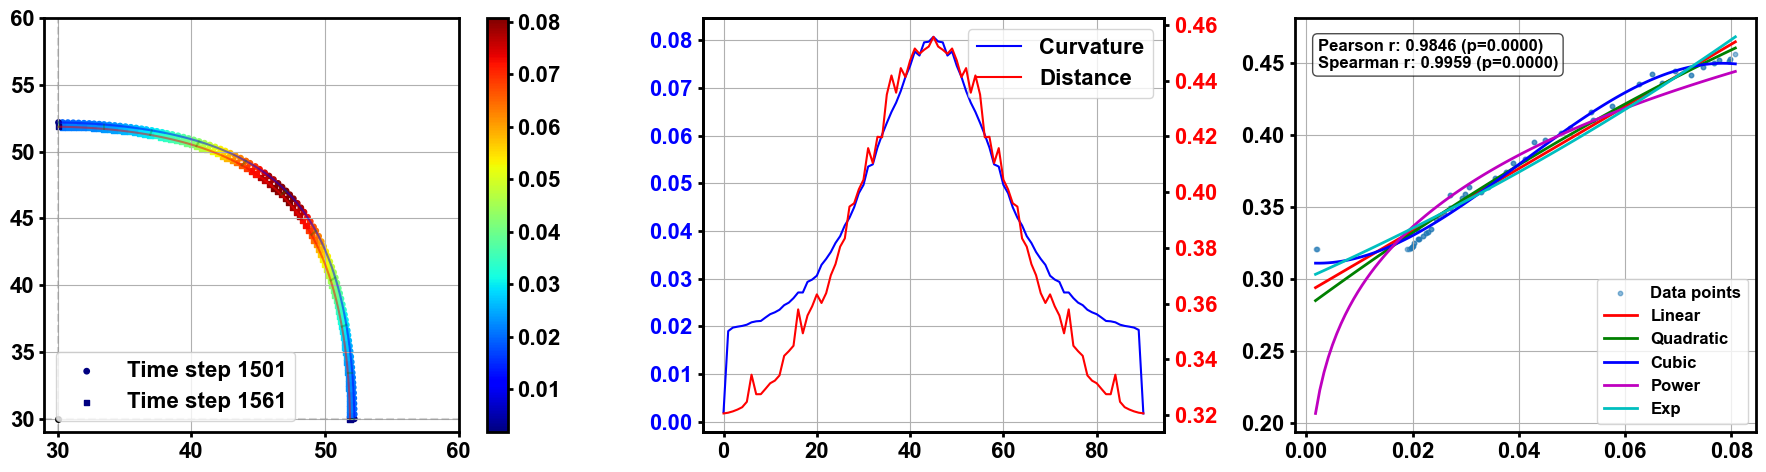


Time step 1501:
  Mean curvature: 0.041121
  Max curvature: 0.080754
  Min curvature: 0.001745

Fitting results:
  Pearson correlation: r = 0.984608, p = 0.000000
  Spearman correlation: r = 0.995890, p = 0.000000
  Linear fit: v_n = 0.289934 + 2.161064κ
  Quadratic fit: v_n = 0.279986 + 2.711630κ + -5.949254κ²
  Cubic fit: v_n = 0.311068 + -0.332456κ + 76.120067κ² + -629.439979κ³
  Power law fit: v_n = 0.733874|κ|^0.199800
  Exponential fit: v_n = 0.300074exp(5.501787κ)


In [7]:
# 设置数据目录
data_dir = '/Users/yanyu/Desktop/课题组文章/金晓强老师/AS审稿意见/20251102代码/interface_data_Lx60_Ly60_afr0.25_csv'

# 示例用法
# 1. 分析单个时间步
# data = analyze_single_timestep(data_dir, 301)

# 2. 分析两个时间步之间的演化
data1, data2, distances = analyze_two_timesteps(data_dir, 1501, 1561)

# 3. 分析所有时间步之间的关系
# all_curvatures, all_distances, all_time_pairs = analyze_all_timesteps(data_dir)

# 您可以取消注释上面的任何一行来运行相应的分析